In [1]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
require(gridExtra)

-- Attaching packages --------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6      v purrr   0.3.4 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.1 
v readr   2.1.2      v forcats 0.5.2 

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
-- Conflicts ------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'broom' was built under R version 4.1.3"
Warning message:
"package 'repr' was built under R version 4.1.2"
Warning m

In [18]:
employment <- read_csv("https://raw.githubusercontent.com/GWilliam02/STAT201-Project/main/data/employmentData.csv")
employment_clean <- employment |>
                    select(NOC_10 ,HRLYEARN,AGE_12) |>
                    filter(!is.na(HRLYEARN)) |>
                    filter(NOC_10 == "03") |>    #Filters out everyone with STEM Occupations
                    filter(AGE_12=="02"|AGE_12=="06") |>
                    select(-NOC_10) |>
                    rename(age_group = AGE_12,
                          hourly_wage = HRLYEARN) |>
                    mutate(age_group = case_when(age_group == "02" ~ "1",
                                                         age_group == "06" ~ "2")
                          ,hourly_wage = hourly_wage/100)
                    
                

head(employment_clean)

Rows: 108064 Columns: 60
-- Column specification --------------------------------------------------
Delimiter: ","
chr  (7): SURVMNTH, AGE_12, NAICS_21, NOC_10, NOC_43, WHYLEFTN, EFAMTYPE
dbl (53): REC_NUM, SURVYEAR, LFSSTAT, PROV, CMA, AGE_6, SEX, MARSTAT, EDUC, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


hourly_wage,age_group
<dbl>,<chr>
28.85,2
76.92,2
46.00,2
35.90,2
32.21,2
25.00,1


In [4]:
tidy(
    t.test(
            x = pull(filter(employment_clean, age_group == "2"), hourly_wage),
            y = pull(filter(employment_clean, age_group == "1"), hourly_wage),
            alternative = "less"
    ))

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
19.34034,46.0552,26.71486,22.15625,1,762.8401,-Inf,20.77789,Welch Two Sample t-test,less


In [11]:
x <- employment_clean |>
        filter(age_group == 1) |>
        summarize(mean = mean(hourly_wage),
                 var = var(hourly_wage),
                 n = n())

y <- employment_clean |>
        filter(age_group == 2) |>
        summarize(mean = mean(hourly_wage),
                 var = var(hourly_wage),
                 n = n())

x
y

mean,var,n
<dbl>,<dbl>,<int>
26.71486,62.9961,220


mean,var,n
<dbl>,<dbl>,<int>
46.0552,278.7137,586


In [6]:
t <- (x$mean-y$mean)/sqrt(x$var/x$n + y$var/y$n)
t

[1] -22.15625

In [7]:
v <- 762.8

In [ ]:
# x_bootstrap <- employment_clean |>
#         filter(age_group == 1) |>
#         select(-age_group) |>
#         specify(response = hourly_wage) |>
#         generate(reps = 1000, type = "bootstrap") |>
#         calculate(stat = "mean")

# y_bootstrap <- employment_clean |>
#         filter(age_group == 2) |>
#         select(-age_group) |>
#         specify(response = hourly_wage) |>
#         generate(reps = 1000, type = "bootstrap") |>
#         calculate(stat = "mean")


In [ ]:
# x_ci <- x_bootstrap |>
#             get_ci(level = 0.95, type = "percentile")
# y_ci <- y_bootstrap |>
#             get_ci(level =0.95, type = "percentile")

# x_ci
# y_ci

In [ ]:
# diff_ci <- tibble(lower_ci = lower_ci <- x_ci$lower_ci - y_ci$upper_ci,
#                  upper_ci = upper_ci <- x_ci$upper_ci - y_ci$lower_ci)
# diff_ci

In [14]:
head(employment_clean)

hourly_wage,age_group
<dbl>,<dbl>
28.85,2
76.92,2
46.00,2
35.90,2
32.21,2
25.00,1


In [37]:
null_model_wage <- employment_clean |>
                    specify(formula = hourly_wage ~ age_group) |>
                    generate(reps = 1000, type = "bootstrap") |>
                    calculate(stat = "diff in means", order = c("1","2"))

head(null_model_wage)

replicate,stat
<int>,<dbl>
1,-18.38792
2,-18.60045
3,-20.78180
4,-20.56874
5,-18.31450
6,-19.44433


p_value
<dbl>
0.511


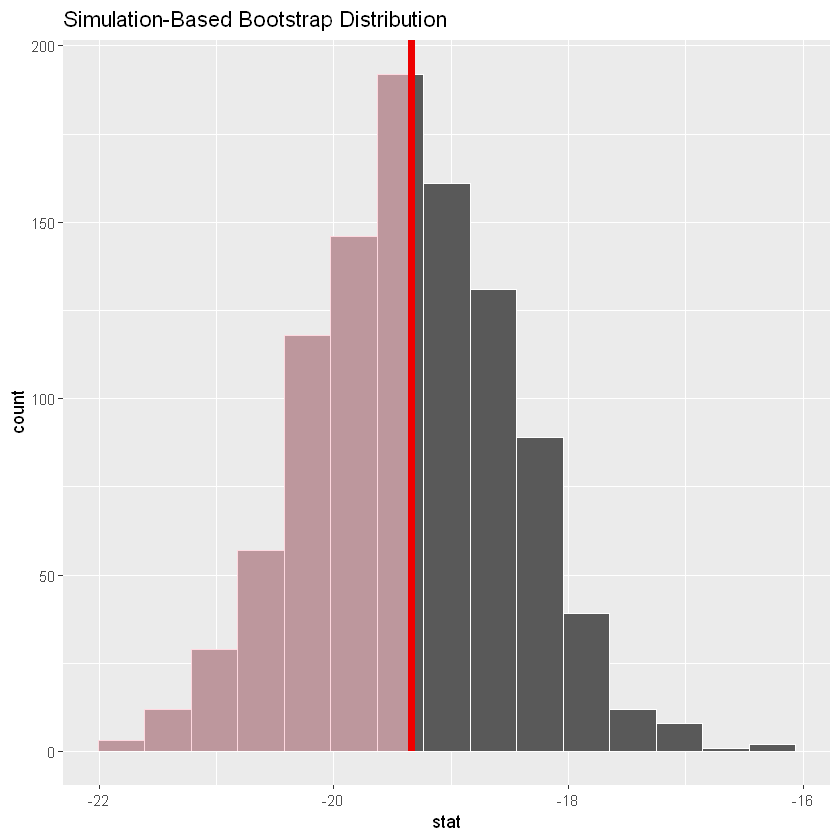

In [38]:
wage_results_plot <- null_model_wage |>
                    visualize() +
                    shade_p_value(obs_stat = (x$mean-y$mean), direction = "less")
wage_results_plot
wage_p_value <- null_model_wage |>
                get_p_value(obs_stat = (x$mean-y$mean), direction = "less")
wage_p_value